# 604: Final Project - Team 23
## Submission for Bhavesh Ram

## Import Packages and Train Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import seaborn as sns
import itertools
from math import sqrt
from datetime import timedelta

In [2]:
data = pd.read_csv('train.csv')
data

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77197,2020-03-15 23:10:00+00:00,272.852287,23.500851,43.740629,-0.524250,-0.108540,-0.108540,63.668076,56.801410,1029.697556,64.904780,64.000634,35.012077,35.406250,182.00,54.889963,9.243551,2.0,182.00,5.156629
77198,2020-03-15 23:20:00+00:00,295.675931,23.409183,43.529209,-0.684376,-0.168882,-0.168882,63.361840,56.551527,1032.996150,64.109157,63.189782,35.004216,35.280933,182.00,60.673948,9.269149,2.0,182.00,5.257433
77199,2020-03-15 23:30:00+00:00,295.127333,23.336964,43.331115,-0.743521,-0.292512,-0.292512,63.156279,56.393276,1031.935870,63.740245,62.798514,35.003815,35.140925,182.00,59.551241,9.252811,2.0,182.00,5.188531
77200,2020-03-15 23:40:00+00:00,342.942216,23.310323,43.169442,-0.955621,-0.516466,-0.516466,63.191997,56.273992,1047.165900,63.657965,62.699627,35.003815,35.093750,182.00,69.460091,9.385111,2.0,182.00,5.408458


In [69]:

# Convert 'Datetime' to datetime object and set it as the index
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

# Resample the data to daily means
daily_data = data.resample('D').mean()


In [70]:
daily_data

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,366.223561,25.528849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.727612,74.042120,NaN,NaN,276.727612,5.263797
2018-01-02 00:00:00+00:00,462.550740,25.357526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.105603,93.555723,NaN,NaN,274.105603,5.390719
2018-01-03 00:00:00+00:00,454.417752,24.379363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,286.369130,91.627843,NaN,NaN,286.369130,5.295225
2018-01-04 00:00:00+00:00,369.952190,24.912347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,284.445471,74.360621,NaN,NaN,284.445471,5.094994
2018-01-05 00:00:00+00:00,319.446595,23.535679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,292.013293,64.366148,NaN,NaN,292.013293,4.915224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11 00:00:00+00:00,466.289248,28.276232,44.059155,0.482881,0.934002,0.934002,64.106761,56.921031,1163.017505,67.939614,67.174603,38.635532,39.955577,183.729298,71.852813,10.420975,2.030612,183.729298,5.385570
2020-03-12 00:00:00+00:00,570.315539,29.094133,44.476550,1.206977,1.629283,1.629283,64.051326,56.194520,1217.638162,70.008635,69.288543,39.978688,40.757739,180.773250,84.040654,10.931663,2.033333,180.773250,5.693483
2020-03-13 00:00:00+00:00,619.637333,30.088163,45.903233,2.168904,2.609776,2.609776,65.348205,57.663415,1213.959374,72.745844,72.096953,39.562485,41.600482,187.621975,99.693231,10.884414,2.059259,187.621975,5.765318


# EDA

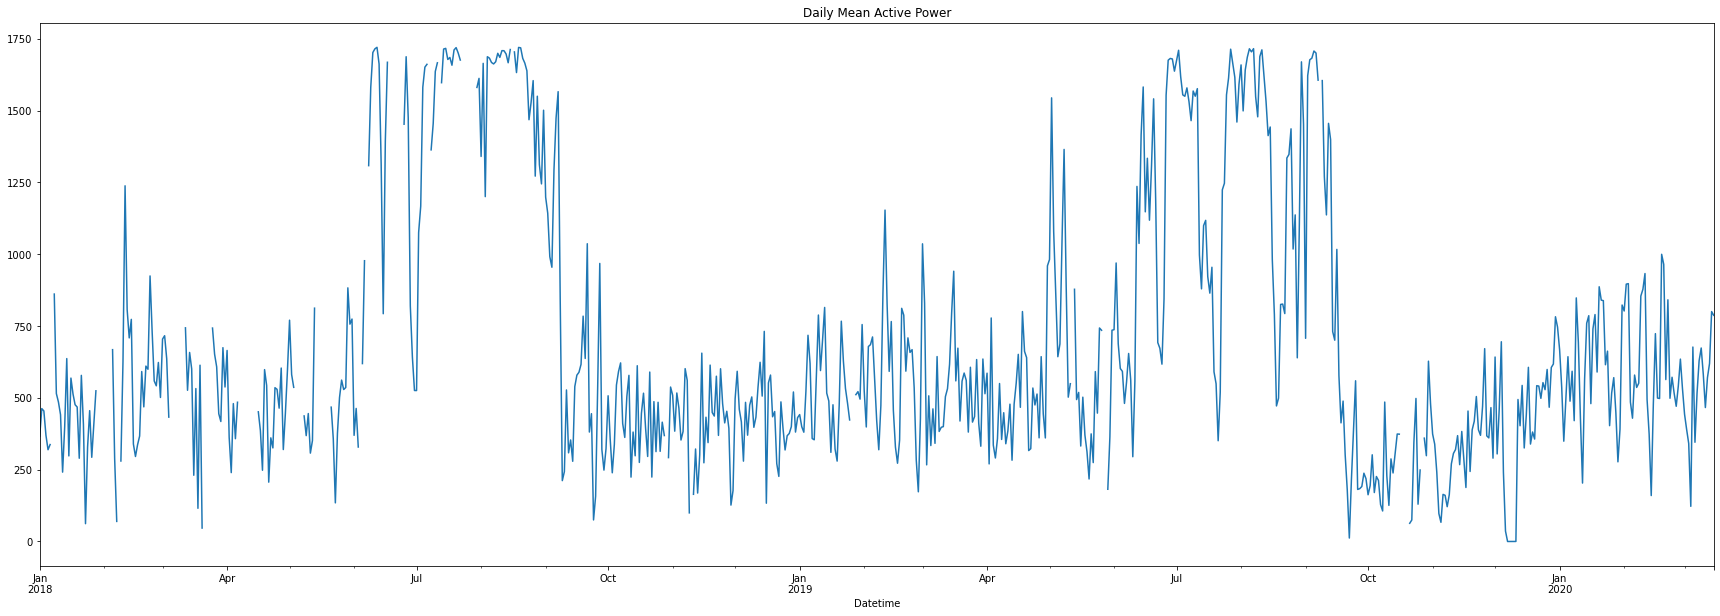

In [71]:

# EDA: Charting ActivePower

plt.figure(figsize=(30, 10))
daily_data['ActivePower'].plot(title='Daily Mean Active Power')
plt.show()



C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



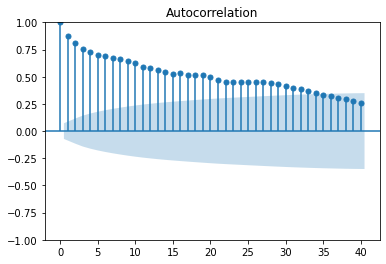

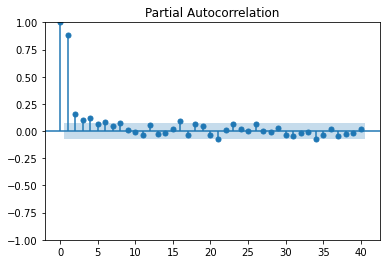

In [72]:
# EDA: ACF and PACF plots
plot_acf(daily_data['ActivePower'].dropna(), lags=40)
plot_pacf(daily_data['ActivePower'].dropna(), lags=40)
plt.show()

The behavior of the ACF and PACF seem to show that the series could exhibit a strong AR component, which makes sense given persistence in weather patterns (generally speaking, these can last in days or seasons) and does not seem to be very stationary.

Also it seems that during June to September, there is higher generation of power, perhaps these are summer months which generate storms.

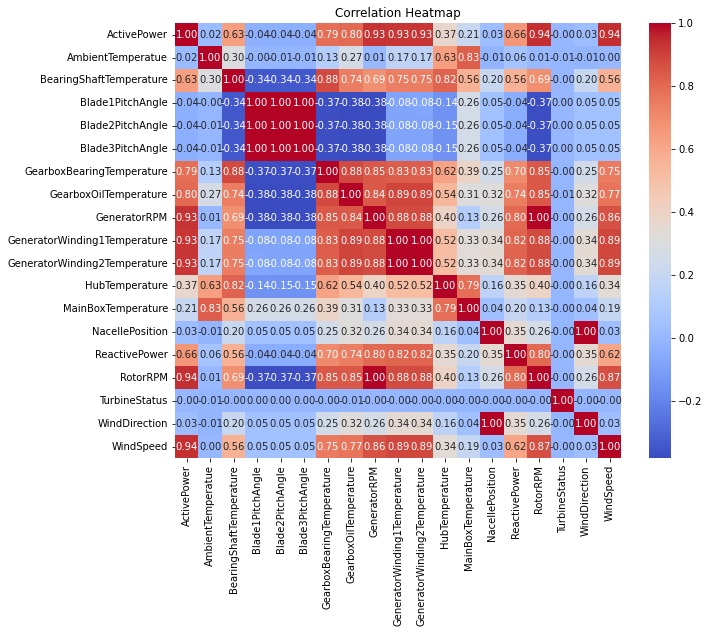

WindSpeed                       0.937769
RotorRPM                        0.935596
GeneratorRPM                    0.933973
GeneratorWinding2Temperature    0.929192
GeneratorWinding1Temperature    0.927954
GearboxOilTemperature           0.802623
GearboxBearingTemperature       0.785132
ReactivePower                   0.662881
BearingShaftTemperature         0.634189
HubTemperature                  0.374506
MainBoxTemperature              0.207052
NacellePosition                 0.025600
WindDirection                   0.025600
AmbientTemperatue               0.017301
TurbineStatus                  -0.001168
Blade1PitchAngle               -0.039899
Blade3PitchAngle               -0.040065
Blade2PitchAngle               -0.040065
Name: ActivePower, dtype: float64


In [73]:

# Calculate the correlation matrix
corr = data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


active_power_corr = corr['ActivePower']
active_power_corr = active_power_corr.drop(labels=['ActivePower'])
sorted_corr = active_power_corr.sort_values(ascending=False)

# Print the sorted correlations
print(sorted_corr)


Based on the above heatmap, we can see that perfect colinearity in Blade Pitch Angles (1-3) exists. 
Strong colinearity also exists between other features, as we would expect. 
Since we're interested in forecasting ActivePower, after removing correlations that exhibit strong colinearity with one another, its interesting to note the presence of strong positive correlations between ActivePower and:

        - WindSpeed                       0.937
        - RotorRPM                        0.936
        - GeneratorWinding2Temperature    0.929
        - GeneratorRPM                    0.933
        - GearboxOilTemperature           0.803
        - ReactivePower                   0.663
        
  Windspeed seems to be logically correlated with the other variables, but perhaps this alludes to WindSpeed being a valuable external predictor of ActivePower.
     

# Data Cleaning and Initialization

In [74]:
#Check for missing dates
# Generate a complete range of dates
start_date = daily_data.index.min()
end_date = daily_data.index.max()
complete_dates = pd.date_range(start=start_date, end=end_date, freq='D')  # 'D' for daily frequency

# Identify missing dates
missing_dates = complete_dates.difference(daily_data.index)

# Output missing dates
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='D')


In [75]:
# Check for remaining NaNs in each column
nan_counts = daily_data.isna().sum()

# Print the NaN count for each column
for column in nan_counts.index:
    print(f"Total NaN count in '{column}': {nan_counts[column]}")

Total NaN count in 'ActivePower': 71
Total NaN count in 'AmbientTemperatue': 75
Total NaN count in 'BearingShaftTemperature': 344
Total NaN count in 'Blade1PitchAngle': 499
Total NaN count in 'Blade2PitchAngle': 499
Total NaN count in 'Blade3PitchAngle': 499
Total NaN count in 'GearboxBearingTemperature': 344
Total NaN count in 'GearboxOilTemperature': 344
Total NaN count in 'GeneratorRPM': 344
Total NaN count in 'GeneratorWinding1Temperature': 344
Total NaN count in 'GeneratorWinding2Temperature': 344
Total NaN count in 'HubTemperature': 344
Total NaN count in 'MainBoxTemperature': 344
Total NaN count in 'NacellePosition': 74
Total NaN count in 'ReactivePower': 71
Total NaN count in 'RotorRPM': 344
Total NaN count in 'TurbineStatus': 340
Total NaN count in 'WindDirection': 74
Total NaN count in 'WindSpeed': 72


In [76]:
daily_data.fillna(method='bfill', inplace = True) #back fill for NaNs obs

In [77]:
# Check for remaining NaNs in each column
nan_counts = daily_data.isna().sum()

# Print the NaN count for each column
for column in nan_counts.index:
    print(f"Total NaN count in '{column}': {nan_counts[column]}")

Total NaN count in 'ActivePower': 0
Total NaN count in 'AmbientTemperatue': 0
Total NaN count in 'BearingShaftTemperature': 0
Total NaN count in 'Blade1PitchAngle': 0
Total NaN count in 'Blade2PitchAngle': 0
Total NaN count in 'Blade3PitchAngle': 0
Total NaN count in 'GearboxBearingTemperature': 0
Total NaN count in 'GearboxOilTemperature': 0
Total NaN count in 'GeneratorRPM': 0
Total NaN count in 'GeneratorWinding1Temperature': 0
Total NaN count in 'GeneratorWinding2Temperature': 0
Total NaN count in 'HubTemperature': 0
Total NaN count in 'MainBoxTemperature': 0
Total NaN count in 'NacellePosition': 0
Total NaN count in 'ReactivePower': 0
Total NaN count in 'RotorRPM': 0
Total NaN count in 'TurbineStatus': 0
Total NaN count in 'WindDirection': 0
Total NaN count in 'WindSpeed': 0


No more NaNs or missing dates. Lets proceed with some Analysis and Modelling.

In [78]:
#First Lets split our cleaned data into train and validations sets
# We'll save the last 15 days of data to test all of our models on

daily_data_save_orig = daily_data #Make a copy of the whole data set to train our best model on at the end

train, test_final = daily_data_save_orig[:-15], daily_data_save_orig[-15:]

train


,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,366.223561,25.528849,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,276.727612,74.042120,15.649013,1.957447,276.727612,5.263797
2018-01-02 00:00:00+00:00,462.550740,25.357526,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,274.105603,93.555723,15.649013,1.957447,274.105603,5.390719
2018-01-03 00:00:00+00:00,454.417752,24.379363,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,286.369130,91.627843,15.649013,1.957447,286.369130,5.295225
2018-01-04 00:00:00+00:00,369.952190,24.912347,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,284.445471,74.360621,15.649013,1.957447,284.445471,5.094994
2018-01-05 00:00:00+00:00,319.446595,23.535679,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,292.013293,64.366148,15.649013,1.957447,292.013293,4.915224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25 00:00:00+00:00,516.014263,27.342190,42.747846,1.115362,1.571159,1.571159,63.529065,55.708862,1152.188781,66.989596,66.260159,37.282285,38.629440,179.154689,88.983902,10.328576,2.303030,179.154689,5.584996
2020-02-26 00:00:00+00:00,470.661244,27.625525,42.870164,-0.360082,0.211408,0.211408,65.609051,57.623263,1158.356614,66.185684,65.437812,35.502224,39.156773,172.022451,95.088928,10.385612,2.000000,172.022451,5.637419
2020-02-27 00:00:00+00:00,541.003574,27.439414,43.347578,0.723516,1.184950,1.184950,64.796991,56.730206,1192.237009,67.452270,66.789682,36.055745,38.783614,169.165909,108.164756,10.696756,12.198529,169.165909,5.638373


In [79]:
daily_data = train
daily_data

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,366.223561,25.528849,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,276.727612,74.042120,15.649013,1.957447,276.727612,5.263797
2018-01-02 00:00:00+00:00,462.550740,25.357526,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,274.105603,93.555723,15.649013,1.957447,274.105603,5.390719
2018-01-03 00:00:00+00:00,454.417752,24.379363,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,286.369130,91.627843,15.649013,1.957447,286.369130,5.295225
2018-01-04 00:00:00+00:00,369.952190,24.912347,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,284.445471,74.360621,15.649013,1.957447,284.445471,5.094994
2018-01-05 00:00:00+00:00,319.446595,23.535679,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,292.013293,64.366148,15.649013,1.957447,292.013293,4.915224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25 00:00:00+00:00,516.014263,27.342190,42.747846,1.115362,1.571159,1.571159,63.529065,55.708862,1152.188781,66.989596,66.260159,37.282285,38.629440,179.154689,88.983902,10.328576,2.303030,179.154689,5.584996
2020-02-26 00:00:00+00:00,470.661244,27.625525,42.870164,-0.360082,0.211408,0.211408,65.609051,57.623263,1158.356614,66.185684,65.437812,35.502224,39.156773,172.022451,95.088928,10.385612,2.000000,172.022451,5.637419
2020-02-27 00:00:00+00:00,541.003574,27.439414,43.347578,0.723516,1.184950,1.184950,64.796991,56.730206,1192.237009,67.452270,66.789682,36.055745,38.783614,169.165909,108.164756,10.696756,12.198529,169.165909,5.638373


# Analysis and Preperation for Model Fitting

In [80]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [81]:
#check stationarity with adf test
adf_test(daily_data['ActivePower'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -3.228491
p-value                          0.018394
#Lags Used                       7.000000
Number of Observations Used    782.000000
Critical Value (1%)             -3.438740
Critical Value (5%)             -2.865243
Critical Value (10%)            -2.568742
dtype: float64


Looks like its fairly stationary (not at 1% level though)
Lets difference the data.

In [82]:
def diff(data, interval):

    diff = []
    
    for i in range(interval, len(data)):
        value = data.iloc[i] - data.iloc[i - interval]
        diff.append(value)
    

    diff_df = pd.DataFrame(diff, columns=['Diff_Data'])

    # Resetting the index to align with the number of rows in diff_df
    diff_df = diff_df.reset_index(drop=True)

    return diff_df

In [83]:
D1 = diff(daily_data['ActivePower'], interval=1)

In [84]:
D1

,Diff_Data
0,96.327179
1,-8.132988
2,-84.465562
3,-50.505594
4,18.024093
...,...
784,-55.705653
785,-45.353019
786,70.342330
787,93.862565


**Check for Stationarity**

In [85]:
adf_test(D1) #

Results of Augmented Dickey-Fuller Test:
Test Statistic                -7.871750e+00
p-value                        4.963792e-12
#Lags Used                     2.100000e+01
Number of Observations Used    7.670000e+02
Critical Value (1%)           -3.438905e+00
Critical Value (5%)           -2.865316e+00
Critical Value (10%)          -2.568781e+00
dtype: float64


<Figure size 2160x720 with 0 Axes>

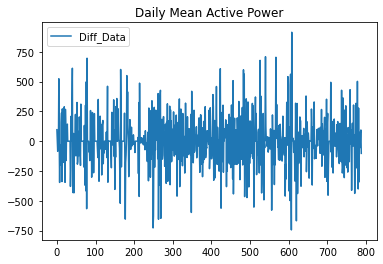

In [86]:
plt.figure(figsize=(30, 10))
D1.plot(title='Daily Mean Active Power')
plt.show()


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



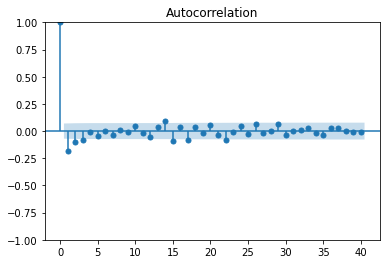

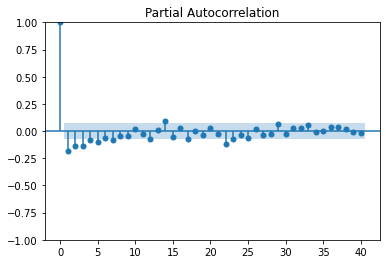

In [87]:
# EDA: ACF and PACF plots
plot_acf(D1, lags=40)
plot_pacf(D1, lags=40)
plt.show()

This looks to be stationary now, according to the above plots and ADF test. 
Lets proceed to model fitting using the differenced data.

# Model Fitting and Selection

### ARIMA

In [88]:
def evaluate_models_cv(dataset, p_values, d_values, q_values):
    K = 5  # Number of folds
    best_rmse, best_cfg = float("inf"), None
    results = []

    # Size of the test set for each fold
    test_size = len(dataset) // K

    for p in p_values:
        for d in d_values:
            for q in q_values:
                cfg = (p, d, q)
                rmse = 0

                for k in range(K):
                    # Sliding window for training set
                    train = dataset[:k * test_size + test_size]
                    test = dataset[k * test_size + test_size:(k + 1) * test_size + test_size]

                    if len(test) == 0:  #check if we've reached the end of the data
                        break

                    try:
                        model = ARIMA(train, order=cfg)
                        model_fit = model.fit()
                        predictions = model_fit.forecast(len(test))
                        rmse += np.sqrt(skmetrics.mean_squared_error(test, predictions))
                    except:
                        rmse += float("inf")

                rmse_avg = rmse / K
                results.append((cfg, rmse_avg))

                if rmse_avg < best_rmse:
                    best_rmse, best_cfg = rmse_avg, cfg
                    print('ARIMA%s RMSE=%.3f' % (cfg, rmse_avg))

    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))

In [89]:
# order selection
p=[0,1,2,3,4]
d=[0]
q=[0,1,2,3,4]

In [90]:
evaluate_models_cv(D1, p,d,q)

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization

Best ARIMANone RMSE=inf


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



This method does not return any viable model.
Below, lets try AutoARIMA

In [91]:
# Cross-validation setup
tscv = TimeSeriesSplit(n_splits=5)

# ARIMA: Auto ARIMA for parameter selection
auto_arima_model = auto_arima(D1, seasonal=True,  trace=True,
                              error_action='ignore', suppress_warnings=True)
best_arima_order = auto_arima_model.order
best_arima_seasonal_order = auto_arima_model.seasonal_order





Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10641.220, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10719.370, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10693.467, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10681.269, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10717.371, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=10642.579, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10642.578, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=10642.856, Time=0.69 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=10642.852, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10640.581, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=10658.285, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=10680.022, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=10638.586, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10679.271, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0

In [92]:
# Fit the best ARIMA model (1,0,1)
model_arima = ARIMA(D1, order=best_arima_order, 
                    seasonal_order=best_arima_seasonal_order)
result_arima = model_arima.fit()
forecast_arima = result_arima.forecast(steps=15)

In [93]:
forecast_arima

789    18.295793
790    10.699472
791     6.272326
792     3.692179
793     2.188465
794     1.312099
795     0.801352
796     0.503688
797     0.330208
798     0.229105
799     0.170181
800     0.135840
801     0.115827
802     0.104163
803     0.097365
Name: predicted_mean, dtype: float64

In [94]:
forecast_arima# Last value from the original non-differenced data
last_value = daily_data['ActivePower'].iloc[-1]
undifferenced_forecasts = [last_value + forecast_arima.iloc[0]]

#integrate the forecasts to original scale
for difference in forecast_arima.iloc[1:]:
    new_value = undifferenced_forecasts[-1] + difference
    undifferenced_forecasts.append(new_value)


In [95]:
undifferenced_forecasts

[550.6175653375952,
 561.3170372500709,
 567.5893628849632,
 571.2815415560269,
 573.4700070137591,
 574.7821063343497,
 575.5834582600785,
 576.0871458988131,
 576.4173543800558,
 576.6464589687625,
 576.8166400692893,
 576.9524804795399,
 577.068307088078,
 577.1724696253418,
 577.2698343257606]

In [96]:
arima_forecasts = undifferenced_forecasts

## Let's try a SARIMAX model

In [97]:
train_size = int(len(daily_data))
X=daily_data[['WindSpeed']]
y=daily_data['ActivePower']
train_X, test_X = X, test_final['WindSpeed']
train_y, test_y = y, test_final['ActivePower']

In [98]:
model=ARIMA(endog=train_y, exog=train_X, order=(1,1,1), trend='t')
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            ActivePower   No. Observations:                  790
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4583.772
Date:                Tue, 05 Dec 2023   AIC                           9177.545
Time:                        15:19:14   BIC                           9200.899
Sample:                    01-01-2018   HQIC                          9186.522
                         - 02-29-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0296      0.046     -0.647      0.517      -0.119       0.060
WindSpeed    235.7270      2.535     92.987      0.000     230.758     240.696
ar.L1          0.6520      0.018     36.540      0.0

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [99]:
pred = results.forecast(len(test_y),exog=train_X['WindSpeed'].tail(15))
pred = pd.DataFrame(pred)

In [100]:
pred['Date'] = pred.index

In [101]:
pred

,predicted_mean,Date
2020-03-01 00:00:00+00:00,489.527548,2020-03-01 00:00:00+00:00
2020-03-02 00:00:00+00:00,657.486409,2020-03-02 00:00:00+00:00
2020-03-03 00:00:00+00:00,527.699661,2020-03-03 00:00:00+00:00
2020-03-04 00:00:00+00:00,462.920951,2020-03-04 00:00:00+00:00
2020-03-05 00:00:00+00:00,814.529888,2020-03-05 00:00:00+00:00
2020-03-06 00:00:00+00:00,854.826431,2020-03-06 00:00:00+00:00
2020-03-07 00:00:00+00:00,539.745076,2020-03-07 00:00:00+00:00
2020-03-08 00:00:00+00:00,756.447103,2020-03-08 00:00:00+00:00
2020-03-09 00:00:00+00:00,515.810347,2020-03-09 00:00:00+00:00
2020-03-10 00:00:00+00:00,508.430402,2020-03-10 00:00:00+00:00


ARIMA still performs better

### ETS

In [102]:
#Param choices
trend_ = [None, 'add', 'mul']
seasonal_ = [None, 'add', 'mul']
seasonal_periods_ = [3,4,12]

#CV
n_splits = 5
window_size = len(daily_data['ActivePower']) // n_splits

best_rmse = float('inf')
best_config = None

# Iterate over all configurations
for trend in trend_:
    for seasonal in seasonal_:
        for seasonal_periods in seasonal_periods_:
            rmses = []

            for i in range(n_splits):
                # Split the data
                train = daily_data['ActivePower'].iloc[:i * window_size + window_size]
                test = daily_data['ActivePower'].iloc[i * window_size + window_size:(i + 1) * window_size + window_size]

                # Check if the test set is empty
                if len(test) == 0:
                    continue

                # Fit the model
                if len(train) > seasonal_periods:
                    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
                    model_fit = model.fit()

                    # Forecast
                    predictions = model_fit.forecast(len(test))

                    # Calculate RMSE
                    rmse = sqrt(mean_squared_error(test, predictions))
                    rmses.append(rmse)

            # Calculate average RMSE for the current configuration
            if rmses:
                average_rmse = sum(rmses) / len(rmses)
                print(f'ETS(trend={trend}, seasonal={seasonal}, periods={seasonal_periods}) - Average RMSE: {average_rmse}')

                # Update best configuration if necessary
                if average_rmse < best_rmse:
                    best_rmse = average_rmse
                    best_config = (trend, seasonal, seasonal_periods)

# Print the best configuration
print(f'Best Configuration: {best_config} - RMSE: {best_rmse}')




ETS(trend=None, seasonal=None, periods=3) - Average RMSE: 429.1012340845688
ETS(trend=None, seasonal=None, periods=4) - Average RMSE: 429.1012340845688
ETS(trend=None, seasonal=None, periods=12) - Average RMSE: 429.1012340845688
ETS(trend=None, seasonal=add, periods=3) - Average RMSE: 429.50483222516266
ETS(trend=None, seasonal=add, periods=4) - Average RMSE: 437.3631740293527
ETS(trend=None, seasonal=add, periods=12) - Average RMSE: 441.0915802279431
ETS(trend=None, seasonal=mul, periods=3) - Average RMSE: 429.22034891277724
ETS(trend=None, seasonal=mul, periods=4) - Average RMSE: 433.74618219823515
ETS(trend=None, seasonal=mul, periods=12) - Average RMSE: 446.54364006840734
ETS(trend=add, seasonal=None, periods=3) - Average RMSE: 991.0433992912575
ETS(trend=add, seasonal=None, periods=4) - Average RMSE: 991.0433992912575
ETS(trend=add, seasonal=None, periods=12) - Average RMSE: 991.0433992912575


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



ETS(trend=add, seasonal=add, periods=3) - Average RMSE: 1023.4293225609638
ETS(trend=add, seasonal=add, periods=4) - Average RMSE: 567.4402743712025
ETS(trend=add, seasonal=add, periods=12) - Average RMSE: 1134.5330932663783


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



ETS(trend=add, seasonal=mul, periods=3) - Average RMSE: 1235.8398888490758
ETS(trend=add, seasonal=mul, periods=4) - Average RMSE: 587.3163195880336
ETS(trend=add, seasonal=mul, periods=12) - Average RMSE: 721.2265950377666
ETS(trend=mul, seasonal=None, periods=3) - Average RMSE: 136927.1316583872
ETS(trend=mul, seasonal=None, periods=4) - Average RMSE: 136927.1316583872
ETS(trend=mul, seasonal=None, periods=12) - Average RMSE: 136927.1316583872
ETS(trend=mul, seasonal=add, periods=3) - Average RMSE: 35064.052423596666


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



ETS(trend=mul, seasonal=add, periods=4) - Average RMSE: 1554.4802737757354


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



ETS(trend=mul, seasonal=add, periods=12) - Average RMSE: 629.7160786309128


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning:

overflow encountered in matmul



ETS(trend=mul, seasonal=mul, periods=3) - Average RMSE: 58382.220177142866


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



ETS(trend=mul, seasonal=mul, periods=4) - Average RMSE: 2532.335940426159


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



ETS(trend=mul, seasonal=mul, periods=12) - Average RMSE: 508.8832631231071
Best Configuration: (None, None, 3) - RMSE: 429.1012340845688


C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning:

overflow encountered in matmul

C:\Users\bhave\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [103]:
# Fit model on entire dataset
final_model = ExponentialSmoothing(daily_data['ActivePower'], trend='add', seasonal='add', seasonal_periods=12)
final_model_fit = final_model.fit()

# Forecast for the next 15 days
ets_forecasts = final_model_fit.forecast(15)
ets_forecasts


2020-03-01 00:00:00+00:00    612.105724
2020-03-02 00:00:00+00:00    691.863557
2020-03-03 00:00:00+00:00    629.242434
2020-03-04 00:00:00+00:00    601.936626
2020-03-05 00:00:00+00:00    604.722831
2020-03-06 00:00:00+00:00    547.094463
2020-03-07 00:00:00+00:00    552.307050
2020-03-08 00:00:00+00:00    541.929381
2020-03-09 00:00:00+00:00    615.916375
2020-03-10 00:00:00+00:00    653.690666
2020-03-11 00:00:00+00:00    580.840259
2020-03-12 00:00:00+00:00    561.360033
2020-03-13 00:00:00+00:00    629.243684
2020-03-14 00:00:00+00:00    709.001517
2020-03-15 00:00:00+00:00    646.380393
Freq: D, dtype: float64

In [104]:
#saving to a df to later add to .csv file
ets_forecasts_df = pd.DataFrame(ets_forecasts.values, columns=['ETS_Predictions'])

### Theta Model

In [105]:
# Cross-validation parameters
n_splits = 5
window_size = len(daily_data['ActivePower']) // n_splits
n_forecast = 15  # Number of days to forecast

# Best model tracking (though we don't have parameters to tune here)
best_rmse = float('inf')

rmses = []

# Cross-validation
for i in range(n_splits):
    # Split the data
    train = daily_data['ActivePower'].iloc[:i * window_size + window_size]
    test = daily_data['ActivePower'].iloc[i * window_size + window_size:(i + 1) * window_size + window_size]

    # Check if the test set is empty
    if len(test) == 0:
        continue

    # Fit the Theta model
    model = ThetaModel(train)
    model_fit = model.fit()

    # Forecast
    predictions = model_fit.forecast(len(test))

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(test, predictions))
    rmses.append(rmse)

# Calculate average RMSE
average_rmse = sum(rmses) / len(rmses)
print(f'Theta Model - Average RMSE: {average_rmse}')




Theta Model - Average RMSE: 418.2177004883041


In [106]:
# Fit model on entire dataset
final_model = ThetaModel(daily_data['ActivePower'])
final_model_fit = final_model.fit()



In [107]:
# Forecast for the next 15 days
theta_forecast = final_model_fit.forecast(n_forecast)
print(theta_forecast)

2020-03-01 00:00:00+00:00    549.378639
2020-03-02 00:00:00+00:00    553.269324
2020-03-03 00:00:00+00:00    552.059524
2020-03-04 00:00:00+00:00    577.936758
2020-03-05 00:00:00+00:00    600.686842
2020-03-06 00:00:00+00:00    546.015791
2020-03-07 00:00:00+00:00    549.179664
2020-03-08 00:00:00+00:00    548.876310
2020-03-09 00:00:00+00:00    552.766995
2020-03-10 00:00:00+00:00    551.557195
2020-03-11 00:00:00+00:00    577.434429
2020-03-12 00:00:00+00:00    600.184514
2020-03-13 00:00:00+00:00    545.513462
2020-03-14 00:00:00+00:00    548.677335
2020-03-15 00:00:00+00:00    548.373981
Freq: D, Name: forecast, dtype: float64


### Prophet

In [108]:
daily_data

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,366.223561,25.528849,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,276.727612,74.042120,15.649013,1.957447,276.727612,5.263797
2018-01-02 00:00:00+00:00,462.550740,25.357526,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,274.105603,93.555723,15.649013,1.957447,274.105603,5.390719
2018-01-03 00:00:00+00:00,454.417752,24.379363,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,286.369130,91.627843,15.649013,1.957447,286.369130,5.295225
2018-01-04 00:00:00+00:00,369.952190,24.912347,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,284.445471,74.360621,15.649013,1.957447,284.445471,5.094994
2018-01-05 00:00:00+00:00,319.446595,23.535679,46.628478,1.578705,2.092213,2.092213,74.093830,61.986985,1745.545938,108.482511,107.865490,39.943926,38.489284,292.013293,64.366148,15.649013,1.957447,292.013293,4.915224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25 00:00:00+00:00,516.014263,27.342190,42.747846,1.115362,1.571159,1.571159,63.529065,55.708862,1152.188781,66.989596,66.260159,37.282285,38.629440,179.154689,88.983902,10.328576,2.303030,179.154689,5.584996
2020-02-26 00:00:00+00:00,470.661244,27.625525,42.870164,-0.360082,0.211408,0.211408,65.609051,57.623263,1158.356614,66.185684,65.437812,35.502224,39.156773,172.022451,95.088928,10.385612,2.000000,172.022451,5.637419
2020-02-27 00:00:00+00:00,541.003574,27.439414,43.347578,0.723516,1.184950,1.184950,64.796991,56.730206,1192.237009,67.452270,66.789682,36.055745,38.783614,169.165909,108.164756,10.696756,12.198529,169.165909,5.638373


In [109]:
print(daily_data['ActivePower'])
print(daily_data['WindSpeed'])

Datetime
2018-01-01 00:00:00+00:00    366.223561
2018-01-02 00:00:00+00:00    462.550740
2018-01-03 00:00:00+00:00    454.417752
2018-01-04 00:00:00+00:00    369.952190
2018-01-05 00:00:00+00:00    319.446595
                                ...    
2020-02-25 00:00:00+00:00    516.014263
2020-02-26 00:00:00+00:00    470.661244
2020-02-27 00:00:00+00:00    541.003574
2020-02-28 00:00:00+00:00    634.866140
2020-02-29 00:00:00+00:00    532.321773
Freq: D, Name: ActivePower, Length: 790, dtype: float64
Datetime
2018-01-01 00:00:00+00:00    5.263797
2018-01-02 00:00:00+00:00    5.390719
2018-01-03 00:00:00+00:00    5.295225
2018-01-04 00:00:00+00:00    5.094994
2018-01-05 00:00:00+00:00    4.915224
                               ...   
2020-02-25 00:00:00+00:00    5.584996
2020-02-26 00:00:00+00:00    5.637419
2020-02-27 00:00:00+00:00    5.638373
2020-02-28 00:00:00+00:00    5.953927
2020-02-29 00:00:00+00:00    5.646869
Freq: D, Name: WindSpeed, Length: 790, dtype: float64


In [110]:
prophet_df = pd.DataFrame()

prophet_df['ds'] = daily_data.index

prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)
prophet_df['y'] = daily_data['ActivePower'].values
prophet_df['WindSpeed'] = daily_data['WindSpeed'].values


In [111]:
prophet_df

,ds,y,WindSpeed
0,2018-01-01,366.223561,5.263797
1,2018-01-02,462.550740,5.390719
2,2018-01-03,454.417752,5.295225
3,2018-01-04,369.952190,5.094994
4,2018-01-05,319.446595,4.915224
...,...,...,...
785,2020-02-25,516.014263,5.584996
786,2020-02-26,470.661244,5.637419
787,2020-02-27,541.003574,5.638373
788,2020-02-28,634.866140,5.953927


In [112]:
# def parameter grid
param_grid = {  
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 5, 10.0],
    'changepoint_prior_scale':[0.01, 0.05, 0.5, 1, 3],
    'changepoint_range': [0.5, 0.7, 0.9],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [False],
}

#generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

results_list =  [] # to store results

# Iterate over all combinations of parameters
for params in all_params:
    m = Prophet(**params).add_regressor('WindSpeed')
    m.add_seasonality(name='quarterly', period=91, fourier_order=6, prior_scale=.1)
    m.fit(prophet_df)

    # Perform CV
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon='15 days')

    #RMSE Calc
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmse = df_p['rmse'].values[0]

    # Store results
    results_list.append({'params': params, 'rmse': rmse})
    

# best params
results = pd.DataFrame(results_list)
results['rmse'] = pd.to_numeric(results['rmse'], errors='coerce')
best_params = results.loc[results['rmse'].idxmin()]['params']

print(f'Best Parameters: {best_params}')




15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:24 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing
15:19:25 - cmdstanpy - INFO - Chain [1] start processing
15:19:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:26 - cmdstanpy - INFO - Chain [1] start processing
15:19:26 - cmdstanpy - INFO - Chain [1] done processing
15:19:27 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:27 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing
15:19:27 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:27 - cmdstanpy - INFO - Chain [1] start processing
15:19:27 - cmdstanpy - INFO - Chain [1] done processing
15:19:28 - cmdstanpy - INFO - Chain [1] start processing
15:19:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:28 - cmdstanpy - INFO - Chain [1] start processing
15:19:28 - cmdstanpy - INFO - Chain [1] done processing
15:19:28 - cmdstanpy - INFO - Chain [1] start processing
15:19:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:29 - cmdstanpy - INFO - Chain [1] start processing
15:19:29 - cmdstanpy - INFO - Chain [1] done processing
15:19:29 - cmdstanpy - INFO - Chain [1] start processing
15:19:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:29 - cmdstanpy - INFO - Chain [1] start processing
15:19:29 - cmdstanpy - INFO - Chain [1] done processing
15:19:30 - cmdstanpy - INFO - Chain [1] start processing
15:19:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:30 - cmdstanpy - INFO - Chain [1] start processing
15:19:30 - cmdstanpy - INFO - Chain [1] done processing
15:19:30 - cmdstanpy - INFO - Chain [1] start processing
15:19:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:30 - cmdstanpy - INFO - Chain [1] start processing
15:19:30 - cmdstanpy - INFO - Chain [1] done processing
15:19:31 - cmdstanpy - INFO - Chain [1] start processing
15:19:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:31 - cmdstanpy - INFO - Chain [1] start processing
15:19:31 - cmdstanpy - INFO - Chain [1] done processing
15:19:31 - cmdstanpy - INFO - Chain [1] start processing
15:19:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:32 - cmdstanpy - INFO - Chain [1] done processing
15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:32 - cmdstanpy - INFO - Chain [1] start processing
15:19:33 - cmdstanpy - INFO - Chain [1] done processing
15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:33 - cmdstanpy - INFO - Chain [1] start processing
15:19:33 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:35 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing
15:19:35 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:35 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing
15:19:36 - cmdstanpy - INFO - Chain [1] start processing
15:19:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:36 - cmdstanpy - INFO - Chain [1] start processing
15:19:36 - cmdstanpy - INFO - Chain [1] done processing
15:19:36 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:37 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing
15:19:37 - cmdstanpy - INFO - Chain [1] start processing
15:19:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:38 - cmdstanpy - INFO - Chain [1] start processing
15:19:38 - cmdstanpy - INFO - Chain [1] done processing
15:19:38 - cmdstanpy - INFO - Chain [1] start processing
15:19:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:38 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:39 - cmdstanpy - INFO - Chain [1] start processing
15:19:39 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:40 - cmdstanpy - INFO - Chain [1] done processing
15:19:40 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:41 - cmdstanpy - INFO - Chain [1] start processing
15:19:41 - cmdstanpy - INFO - Chain [1] done processing
15:19:42 - cmdstanpy - INFO - Chain [1] start processing
15:19:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:42 - cmdstanpy - INFO - Chain [1] start processing
15:19:42 - cmdstanpy - INFO - Chain [1] done processing
15:19:43 - cmdstanpy - INFO - Chain [1] start processing
15:19:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:43 - cmdstanpy - INFO - Chain [1] start processing
15:19:43 - cmdstanpy - INFO - Chain [1] done processing
15:19:44 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:44 - cmdstanpy - INFO - Chain [1] start processing
15:19:44 - cmdstanpy - INFO - Chain [1] done processing
15:19:45 - cmdstanpy - INFO - Chain [1] start processing
15:19:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:45 - cmdstanpy - INFO - Chain [1] start processing
15:19:45 - cmdstanpy - INFO - Chain [1] done processing
15:19:45 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing
15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:46 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:49 - cmdstanpy - INFO - Chain [1] start processing
15:19:49 - cmdstanpy - INFO - Chain [1] done processing
15:19:49 - cmdstanpy - INFO - Chain [1] start processing
15:19:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:49 - cmdstanpy - INFO - Chain [1] start processing
15:19:49 - cmdstanpy - INFO - Chain [1] done processing
15:19:50 - cmdstanpy - INFO - Chain [1] start processing
15:19:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:50 - cmdstanpy - INFO - Chain [1] start processing
15:19:50 - cmdstanpy - INFO - Chain [1] done processing
15:19:50 - cmdstanpy - INFO - Chain [1] start processing
15:19:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:50 - cmdstanpy - INFO - Chain [1] start processing
15:19:50 - cmdstanpy - INFO - Chain [1] done processing
15:19:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing
15:19:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing
15:19:54 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:54 - cmdstanpy - INFO - Chain [1] start processing
15:19:54 - cmdstanpy - INFO - Chain [1] done processing
15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] done processing
15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:55 - cmdstanpy - INFO - Chain [1] start processing
15:19:56 - cmdstanpy - INFO - Chain [1] done processing
15:19:56 - cmdstanpy - INFO - Chain [1] start processing
15:19:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:56 - cmdstanpy - INFO - Chain [1] start processing
15:19:56 - cmdstanpy - INFO - Chain [1] done processing
15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:57 - cmdstanpy - INFO - Chain [1] done processing
15:19:57 - cmdstanpy - INFO - Chain [1] start processing
15:19:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:20:00 - cmdstanpy - INFO - Chain [1] start processing
15:20:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:00 - cmdstanpy - INFO - Chain [1] start processing
15:20:00 - cmdstanpy - INFO - Chain [1] done processing
15:20:00 - cmdstanpy - INFO - Chain [1] start processing
15:20:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:01 - cmdstanpy - INFO - Chain [1] start processing
15:20:01 - cmdstanpy - INFO - Chain [1] done processing
15:20:01 - cmdstanpy - INFO - Chain [1] start processing
15:20:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:02 - cmdstanpy - INFO - Chain [1] start processing
15:20:02 - cmdstanpy - INFO - Chain [1] done processing
15:20:02 - cmdstanpy - INFO - Chain [1] start processing
15:20:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:03 - cmdstanpy - INFO - Chain [1] start processing
15:20:03 - cmdstanpy - INFO - Chain [1] done processing
15:20:04 - cmdstanpy - INFO - Chain [1] start processing
15:20:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:04 - cmdstanpy - INFO - Chain [1] start processing
15:20:04 - cmdstanpy - INFO - Chain [1] done processing
15:20:05 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:05 - cmdstanpy - INFO - Chain [1] start processing
15:20:05 - cmdstanpy - INFO - Chain [1] done processing
15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:06 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1] done processing
15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:07 - cmdstanpy - INFO - Chain [1] start processing
15:20:08 - cmdstanpy - INFO - Chain [1] done processing
15:20:08 - cmdstanpy - INFO - Chain [1] start processing
15:20:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:08 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing
15:20:09 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:09 - cmdstanpy - INFO - Chain [1] start processing
15:20:09 - cmdstanpy - INFO - Chain [1] done processing
15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:10 - cmdstanpy - INFO - Chain [1] done processing
15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:10 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:12 - cmdstanpy - INFO - Chain [1] start processing
15:20:12 - cmdstanpy - INFO - Chain [1] done processing
15:20:12 - cmdstanpy - INFO - Chain [1] start processing
15:20:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:12 - cmdstanpy - INFO - Chain [1] start processing
15:20:12 - cmdstanpy - INFO - Chain [1] done processing
15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:13 - cmdstanpy - INFO - Chain [1] done processing
15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:13 - cmdstanpy - INFO - Chain [1] start processing
15:20:13 - cmdstanpy - INFO - Chain [1] done processing
15:20:14 - cmdstanpy - INFO - Chain [1] start processing
15:20:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:14 - cmdstanpy - INFO - Chain [1] start processing
15:20:14 - cmdstanpy - INFO - Chain [1] done processing
15:20:14 - cmdstanpy - INFO - Chain [1] start processing
15:20:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:15 - cmdstanpy - INFO - Chain [1] start processing
15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:15 - cmdstanpy - INFO - Chain [1] start processing
15:20:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:15 - cmdstanpy - INFO - Chain [1] start processing
15:20:15 - cmdstanpy - INFO - Chain [1] done processing
15:20:15 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing
15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:16 - cmdstanpy - INFO - Chain [1] start processing
15:20:17 - cmdstanpy - INFO - Chain [1] done processing
15:20:17 - cmdstanpy - INFO - Chain [1] start processing
15:20:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:17 - cmdstanpy - INFO - Chain [1] start processing
15:20:17 - cmdstanpy - INFO - Chain [1] done processing
15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing
15:20:18 - cmdstanpy - INFO - Chain [1] start processing
15:20:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing
15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:19 - cmdstanpy - INFO - Chain [1] start processing
15:20:19 - cmdstanpy - INFO - Chain [1] done processing
15:20:20 - cmdstanpy - INFO - Chain [1] start processing
15:20:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:20 - cmdstanpy - INFO - Chain [1] start processing
15:20:20 - cmdstanpy - INFO - Chain [1] done processing
15:20:20 - cmdstanpy - INFO - Chain [1] start processing
15:20:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:21 - cmdstanpy - INFO - Chain [1] start processing
15:20:21 - cmdstanpy - INFO - Chain [1] done processing
15:20:21 - cmdstanpy - INFO - Chain [1] start processing
15:20:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:21 - cmdstanpy - INFO - Chain [1] start processing
15:20:22 - cmdstanpy - INFO - Chain [1] done processing
15:20:22 - cmdstanpy - INFO - Chain [1] start processing
15:20:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:22 - cmdstanpy - INFO - Chain [1] start processing
15:20:22 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:24 - cmdstanpy - INFO - Chain [1] done processing
15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:25 - cmdstanpy - INFO - Chain [1] start processing
15:20:25 - cmdstanpy - INFO - Chain [1] done processing
15:20:25 - cmdstanpy - INFO - Chain [1] start processing
15:20:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:26 - cmdstanpy - INFO - Chain [1] start processing
15:20:26 - cmdstanpy - INFO - Chain [1] done processing
15:20:26 - cmdstanpy - INFO - Chain [1] start processing
15:20:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:27 - cmdstanpy - INFO - Chain [1] start processing
15:20:27 - cmdstanpy - INFO - Chain [1] done processing
15:20:27 - cmdstanpy - INFO - Chain [1] start processing
15:20:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:28 - cmdstanpy - INFO - Chain [1] start processing
15:20:28 - cmdstanpy - INFO - Chain [1] done processing
15:20:28 - cmdstanpy - INFO - Chain [1] start processing
15:20:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:29 - cmdstanpy - INFO - Chain [1] start processing
15:20:29 - cmdstanpy - INFO - Chain [1] done processing
15:20:29 - cmdstanpy - INFO - Chain [1] start processing
15:20:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:30 - cmdstanpy - INFO - Chain [1] start processing
15:20:30 - cmdstanpy - INFO - Chain [1] done processing
15:20:30 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:31 - cmdstanpy - INFO - Chain [1] done processing
15:20:31 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:32 - cmdstanpy - INFO - Chain [1] start processing
15:20:32 - cmdstanpy - INFO - Chain [1] done processing
15:20:33 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:33 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1] done processing
15:20:33 - cmdstanpy - INFO - Chain [1] start processing
15:20:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:34 - cmdstanpy - INFO - Chain [1] done processing
15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:34 - cmdstanpy - INFO - Chain [1] start processing
15:20:34 - cmdstanpy - INFO - Chain [1] done processing
15:20:35 - cmdstanpy - INFO - Chain [1] start processing
15:20:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:35 - cmdstanpy - INFO - Chain [1] start processing
15:20:35 - cmdstanpy - INFO - Chain [1] done processing
15:20:35 - cmdstanpy - INFO - Chain [1] start processing
15:20:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing
15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing
15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:37 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:37 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing
15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:38 - cmdstanpy - INFO - Chain [1] done processing
15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:38 - cmdstanpy - INFO - Chain [1] start processing
15:20:39 - cmdstanpy - INFO - Chain [1] done processing
15:20:39 - cmdstanpy - INFO - Chain [1] start processing
15:20:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:39 - cmdstanpy - INFO - Chain [1] start processing
15:20:39 - cmdstanpy - INFO - Chain [1] done processing
15:20:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:40 - cmdstanpy - INFO - Chain [1] done processing
15:20:40 - cmdstanpy - INFO - Chain [1] start processing
15:20:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:41 - cmdstanpy - INFO - Chain [1] start processing
15:20:41 - cmdstanpy - INFO - Chain [1] done processing
15:20:41 - cmdstanpy - INFO - Chain [1] start processing
15:20:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:41 - cmdstanpy - INFO - Chain [1] start processing
15:20:41 - cmdstanpy - INFO - Chain [1] done processing
15:20:42 - cmdstanpy - INFO - Chain [1] start processing
15:20:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:42 - cmdstanpy - INFO - Chain [1] start processing
15:20:42 - cmdstanpy - INFO - Chain [1] done processing
15:20:42 - cmdstanpy - INFO - Chain [1] start processing
15:20:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:43 - cmdstanpy - INFO - Chain [1] start processing
15:20:43 - cmdstanpy - INFO - Chain [1] done processing
15:20:43 - cmdstanpy - INFO - Chain [1] start processing
15:20:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:43 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing
15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:44 - cmdstanpy - INFO - Chain [1] start processing
15:20:44 - cmdstanpy - INFO - Chain [1] done processing
15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:45 - cmdstanpy - INFO - Chain [1] start processing
15:20:45 - cmdstanpy - INFO - Chain [1] done processing
15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing
15:20:46 - cmdstanpy - INFO - Chain [1] start processing
15:20:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:47 - cmdstanpy - INFO - Chain [1] start processing
15:20:47 - cmdstanpy - INFO - Chain [1] done processing
15:20:47 - cmdstanpy - INFO - Chain [1] start processing
15:20:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:47 - cmdstanpy - INFO - Chain [1] start processing
15:20:48 - cmdstanpy - INFO - Chain [1] done processing
15:20:48 - cmdstanpy - INFO - Chain [1] start processing
15:20:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:49 - cmdstanpy - INFO - Chain [1] start processing
15:20:49 - cmdstanpy - INFO - Chain [1] done processing
15:20:49 - cmdstanpy - INFO - Chain [1] start processing
15:20:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:50 - cmdstanpy - INFO - Chain [1] start processing
15:20:50 - cmdstanpy - INFO - Chain [1] done processing
15:20:50 - cmdstanpy - INFO - Chain [1] start processing
15:20:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:51 - cmdstanpy - INFO - Chain [1] start processing
15:20:51 - cmdstanpy - INFO - Chain [1] done processing
15:20:52 - cmdstanpy - INFO - Chain [1] start processing
15:20:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:52 - cmdstanpy - INFO - Chain [1] start processing
15:20:52 - cmdstanpy - INFO - Chain [1] done processing
15:20:53 - cmdstanpy - INFO - Chain [1] start processing
15:20:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:53 - cmdstanpy - INFO - Chain [1] start processing
15:20:53 - cmdstanpy - INFO - Chain [1] done processing
15:20:54 - cmdstanpy - INFO - Chain [1] start processing
15:20:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:54 - cmdstanpy - INFO - Chain [1] start processing
15:20:54 - cmdstanpy - INFO - Chain [1] done processing
15:20:55 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:55 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing
15:20:55 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:56 - cmdstanpy - INFO - Chain [1] start processing
15:20:56 - cmdstanpy - INFO - Chain [1] done processing
15:20:56 - cmdstanpy - INFO - Chain [1] start processing
15:20:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:56 - cmdstanpy - INFO - Chain [1] start processing
15:20:56 - cmdstanpy - INFO - Chain [1] done processing
15:20:57 - cmdstanpy - INFO - Chain [1] start processing
15:20:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:57 - cmdstanpy - INFO - Chain [1] start processing
15:20:57 - cmdstanpy - INFO - Chain [1] done processing
15:20:57 - cmdstanpy - INFO - Chain [1] start processing
15:20:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:58 - cmdstanpy - INFO - Chain [1] done processing
15:20:58 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing
15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:20:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:59 - cmdstanpy - INFO - Chain [1] done processing
15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing
15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:00 - cmdstanpy - INFO - Chain [1] start processing
15:21:00 - cmdstanpy - INFO - Chain [1] done processing
15:21:01 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:01 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1] done processing
15:21:01 - cmdstanpy - INFO - Chain [1] start processing
15:21:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:02 - cmdstanpy - INFO - Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing
15:21:02 - cmdstanpy - INFO - Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:02 - cmdstanpy - INFO - Chain [1] start processing
15:21:02 - cmdstanpy - INFO - Chain [1] done processing
15:21:03 - cmdstanpy - INFO - Chain [1] start processing
15:21:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:03 - cmdstanpy - INFO - Chain [1] start processing
15:21:03 - cmdstanpy - INFO - Chain [1] done processing
15:21:03 - cmdstanpy - INFO - Chain [1] start processing
15:21:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:04 - cmdstanpy - INFO - Chain [1] start processing
15:21:04 - cmdstanpy - INFO - Chain [1] done processing
15:21:04 - cmdstanpy - INFO - Chain [1] start processing
15:21:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:04 - cmdstanpy - INFO - Chain [1] start processing
15:21:04 - cmdstanpy - INFO - Chain [1] done processing
15:21:05 - cmdstanpy - INFO - Chain [1] start processing
15:21:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:05 - cmdstanpy - INFO - Chain [1] start processing
15:21:05 - cmdstanpy - INFO - Chain [1] done processing
15:21:05 - cmdstanpy - INFO - Chain [1] start processing
15:21:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:05 - cmdstanpy - INFO - Chain [1] start processing
15:21:06 - cmdstanpy - INFO - Chain [1] done processing
15:21:06 - cmdstanpy - INFO - Chain [1] start processing
15:21:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:06 - cmdstanpy - INFO - Chain [1] start processing
15:21:06 - cmdstanpy - INFO - Chain [1] done processing
15:21:07 - cmdstanpy - INFO - Chain [1] start processing
15:21:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:07 - cmdstanpy - INFO - Chain [1] start processing
15:21:07 - cmdstanpy - INFO - Chain [1] done processing
15:21:07 - cmdstanpy - INFO - Chain [1] start processing
15:21:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:08 - cmdstanpy - INFO - Chain [1] start processing
15:21:08 - cmdstanpy - INFO - Chain [1] done processing
15:21:08 - cmdstanpy - INFO - Chain [1] start processing
15:21:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:09 - cmdstanpy - INFO - Chain [1] start processing
15:21:09 - cmdstanpy - INFO - Chain [1] done processing
15:21:09 - cmdstanpy - INFO - Chain [1] start processing
15:21:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:09 - cmdstanpy - INFO - Chain [1] start processing
15:21:09 - cmdstanpy - INFO - Chain [1] done processing
15:21:10 - cmdstanpy - INFO - Chain [1] start processing
15:21:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:10 - cmdstanpy - INFO - Chain [1] start processing
15:21:10 - cmdstanpy - INFO - Chain [1] done processing
15:21:11 - cmdstanpy - INFO - Chain [1] start processing
15:21:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:11 - cmdstanpy - INFO - Chain [1] start processing
15:21:11 - cmdstanpy - INFO - Chain [1] done processing
15:21:12 - cmdstanpy - INFO - Chain [1] start processing
15:21:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:12 - cmdstanpy - INFO - Chain [1] start processing
15:21:13 - cmdstanpy - INFO - Chain [1] done processing
15:21:13 - cmdstanpy - INFO - Chain [1] start processing
15:21:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:13 - cmdstanpy - INFO - Chain [1] start processing
15:21:14 - cmdstanpy - INFO - Chain [1] done processing
15:21:14 - cmdstanpy - INFO - Chain [1] start processing
15:21:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:14 - cmdstanpy - INFO - Chain [1] start processing
15:21:15 - cmdstanpy - INFO - Chain [1] done processing
15:21:15 - cmdstanpy - INFO - Chain [1] start processing
15:21:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:16 - cmdstanpy - INFO - Chain [1] start processing
15:21:16 - cmdstanpy - INFO - Chain [1] done processing
15:21:16 - cmdstanpy - INFO - Chain [1] start processing
15:21:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

15:21:17 - cmdstanpy - INFO - Chain [1] start processing
15:21:17 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 3, 'changepoint_range': 0.9, 'weekly_seasonality': True, 'daily_seasonality': False}


In [113]:
# Fit best model
best_model = Prophet(**best_params).add_regressor('WindSpeed')
best_model.fit(prophet_df)

15:21:17 - cmdstanpy - INFO - Chain [1] start processing
15:21:17 - cmdstanpy - INFO - Chain [1] done processing


In [114]:
# df future 15 days forecast
future = best_model.make_future_dataframe(periods=15)

# Lets calculate median WindSpeed for each day of the year from historical data as an additional predictor
prophet_df['month_day'] = prophet_df['ds'].dt.strftime('%m-%d')
median_windspeed = prophet_df.groupby('month_day')['WindSpeed'].median()

# Assign median WindSpeed values to future dates based on annual data
future['month_day'] = future['ds'].dt.strftime('%m-%d')
future['WindSpeed'] = future['month_day'].map(median_windspeed)

#there shouldn't be any missing vals at this point, but just in case
future['WindSpeed'].fillna(method='ffill', inplace=True)

# Forecast!
prophet_forecast = best_model.predict(future)


In [115]:
prophet_forecast = best_model.predict(future)
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15))

            ds        yhat  yhat_lower  yhat_upper
790 2020-03-01  803.964038  699.633874  916.482389
791 2020-03-02  756.719518  638.764248  886.966678
792 2020-03-03  488.812826  370.352565  604.665462
793 2020-03-04  547.158097  419.838505  654.200136
794 2020-03-05  553.815440  434.597062  667.499959
795 2020-03-06  619.182413  499.437590  731.519733
796 2020-03-07  547.407429  431.628725  663.159205
797 2020-03-08  632.576209  506.745984  751.809569
798 2020-03-09  534.476352  414.870062  654.218445
799 2020-03-10  568.298193  449.571902  690.772576
800 2020-03-11  552.876495  437.875688  665.224679
801 2020-03-12  606.273330  495.039734  729.961334
802 2020-03-13  554.858443  429.327655  668.924647
803 2020-03-14  621.292791  505.446427  738.462865
804 2020-03-15  658.914878  540.074738  777.717913


In [116]:
prophet_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,WindSpeed,WindSpeed_lower,WindSpeed_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,688.293657,338.070258,570.540168,688.293657,688.293657,-169.126974,-169.126974,-169.126974,-225.516074,...,-10.023844,-10.023844,-10.023844,-46.365256,-46.365256,-46.365256,0.0,0.0,0.0,462.777583
1,2018-01-02,688.640050,346.549550,573.178233,688.640050,688.640050,-179.841238,-179.841238,-179.841238,-224.699935,...,0.983666,0.983666,0.983666,-45.842363,-45.842363,-45.842363,0.0,0.0,0.0,463.940115
2,2018-01-03,688.986442,314.190809,543.988966,688.986442,688.986442,-227.570658,-227.570658,-227.570658,-261.174839,...,11.987347,11.987347,11.987347,-45.591529,-45.591529,-45.591529,0.0,0.0,0.0,427.811603
3,2018-01-04,689.332835,399.515978,624.437548,689.332835,689.332835,-140.623252,-140.623252,-140.623252,-177.058283,...,9.127881,9.127881,9.127881,-45.562913,-45.562913,-45.562913,0.0,0.0,0.0,512.274552
4,2018-01-05,689.679227,508.932332,733.816163,689.679227,689.679227,-27.900454,-27.900454,-27.900454,-68.413697,...,5.190551,5.190551,5.190551,-45.703793,-45.703793,-45.703793,0.0,0.0,0.0,621.265531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,2020-03-11,777.930228,437.875688,665.224679,776.194475,779.324489,-162.840119,-162.840119,-162.840119,-225.053734,...,11.987347,11.987347,11.987347,-74.200962,-74.200962,-74.200962,0.0,0.0,0.0,552.876495
801,2020-03-12,778.771374,495.039734,729.961334,776.803178,780.774012,-104.945238,-104.945238,-104.945238,-172.498044,...,9.127881,9.127881,9.127881,-76.680687,-76.680687,-76.680687,0.0,0.0,0.0,606.273330
802,2020-03-13,779.612519,429.327655,668.924647,777.048191,782.428469,-150.711511,-150.711511,-150.711511,-224.754076,...,5.190551,5.190551,5.190551,-79.233116,-79.233116,-79.233116,0.0,0.0,0.0,554.858443
803,2020-03-14,780.453665,505.446427,738.462865,776.969729,783.769135,-71.108090,-71.108090,-71.108090,-159.160874,...,-6.201860,-6.201860,-6.201860,-81.850925,-81.850925,-81.850925,0.0,0.0,0.0,621.292791


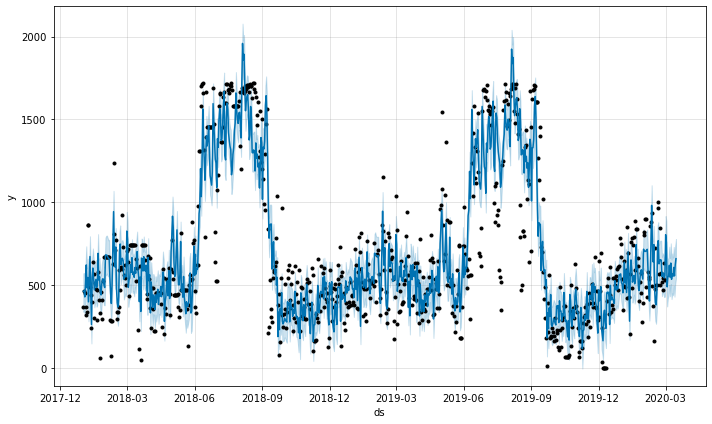

In [117]:
fig1 = m.plot(prophet_forecast)

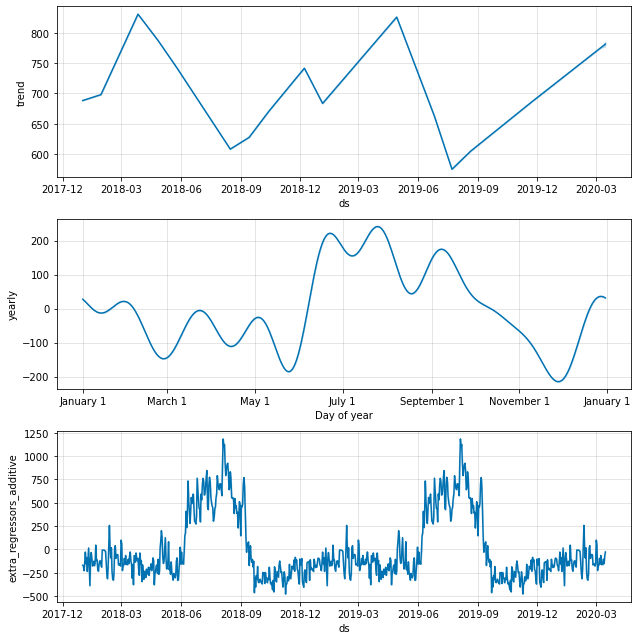

In [118]:
fig2 = m.plot_components(prophet_forecast)

In [119]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, prophet_forecast)

15:21:19 - cmdstanpy - INFO - Chain [1] start processing
15:21:19 - cmdstanpy - INFO - Chain [1] done processing


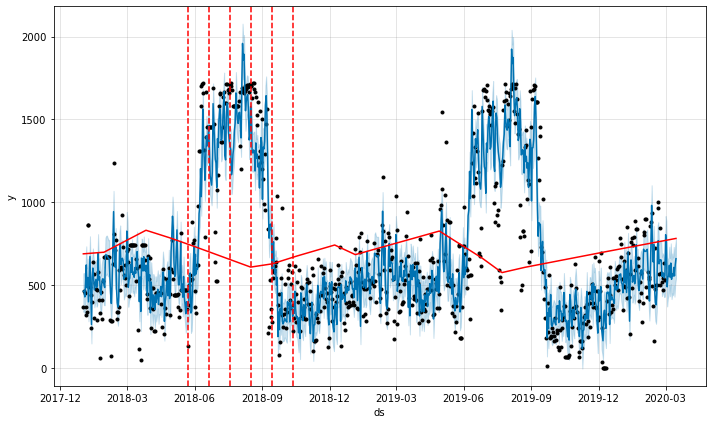

In [120]:
from prophet.plot import add_changepoints_to_plot
m = Prophet(changepoint_range=0.9)
m.fit(prophet_df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(prophet_forecast)
a = add_changepoints_to_plot(fig.gca(), m, prophet_forecast)

**Getting a compilation of the forecasts ready for analysis**

In [121]:
ets_forecasts

2020-03-01 00:00:00+00:00    612.105724
2020-03-02 00:00:00+00:00    691.863557
2020-03-03 00:00:00+00:00    629.242434
2020-03-04 00:00:00+00:00    601.936626
2020-03-05 00:00:00+00:00    604.722831
2020-03-06 00:00:00+00:00    547.094463
2020-03-07 00:00:00+00:00    552.307050
2020-03-08 00:00:00+00:00    541.929381
2020-03-09 00:00:00+00:00    615.916375
2020-03-10 00:00:00+00:00    653.690666
2020-03-11 00:00:00+00:00    580.840259
2020-03-12 00:00:00+00:00    561.360033
2020-03-13 00:00:00+00:00    629.243684
2020-03-14 00:00:00+00:00    709.001517
2020-03-15 00:00:00+00:00    646.380393
Freq: D, dtype: float64

In [122]:
prophet_forecast = prophet_forecast[['ds', 'yhat']].tail(15)

# Rename the columns
prophet_forecast.columns = ['Date', 'Prophet']

In [123]:
merged_forecasts = pd.DataFrame({'Date': ets_forecasts.index})

# Add forecasts to the DataFrame
merged_forecasts['ETS'] = ets_forecasts.values
merged_forecasts['ARIMA'] = arima_forecasts
merged_forecasts['Prophet'] = prophet_forecast['Prophet'].values  # Assuming prophet_forecasts is a DataFrame
merged_forecasts['Theta'] = theta_forecast.values

# Convert the 'Date' to datetime if it's not already
merged_forecasts['Date'] = pd.to_datetime(merged_forecasts['Date'])

In [124]:
merged_forecasts

,Date,ETS,ARIMA,Prophet,Theta
0,2020-03-01 00:00:00+00:00,612.105724,550.617565,803.964038,549.378639
1,2020-03-02 00:00:00+00:00,691.863557,561.317037,756.719518,553.269324
2,2020-03-03 00:00:00+00:00,629.242434,567.589363,488.812826,552.059524
3,2020-03-04 00:00:00+00:00,601.936626,571.281542,547.158097,577.936758
4,2020-03-05 00:00:00+00:00,604.722831,573.470007,553.815440,600.686842
5,2020-03-06 00:00:00+00:00,547.094463,574.782106,619.182413,546.015791
6,2020-03-07 00:00:00+00:00,552.307050,575.583458,547.407429,549.179664
7,2020-03-08 00:00:00+00:00,541.929381,576.087146,632.576209,548.876310
8,2020-03-09 00:00:00+00:00,615.916375,576.417354,534.476352,552.766995
9,2020-03-10 00:00:00+00:00,653.690666,576.646459,568.298193,551.557195


# Selecting the Best Model

In [125]:
test_final

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2020-03-01 00:00:00+00:00,443.058496,27.808993,42.809160,1.743321,2.237514,2.237514,62.922848,55.564361,1132.454152,65.898412,65.141722,36.768596,39.242432,173.929233,80.205808,10.150109,2.025000,173.929233,5.307277
2020-03-02 00:00:00+00:00,390.027361,28.100901,42.249381,2.499737,2.948073,2.948073,61.991998,54.961840,1095.696948,63.627997,62.893369,37.175908,39.313489,166.353042,76.048749,9.824197,2.051020,166.353042,5.134141
2020-03-03 00:00:00+00:00,341.133560,30.029204,42.564554,3.352476,3.916556,3.916556,61.086330,54.705347,1069.154720,62.561734,61.847427,38.661301,40.973484,187.144312,65.528430,9.605869,2.026316,187.144312,4.861985
2020-03-04 00:00:00+00:00,122.348957,30.736954,41.050796,3.615269,3.825840,3.825840,56.977297,51.902951,969.056676,55.641067,54.897531,40.213843,41.340463,153.887760,23.680851,8.699883,2.078125,153.887760,3.947053
2020-03-05 00:00:00+00:00,676.893151,32.441309,41.821379,4.202963,4.679106,4.679106,61.358879,54.558300,1101.440777,60.460871,59.926774,40.069965,43.500890,190.679124,86.375385,9.869622,6.509804,190.679124,5.949888
2020-03-06 00:00:00+00:00,345.379836,25.423446,45.528870,2.302958,2.866026,2.866026,66.457802,57.630624,1300.620234,76.321828,75.603281,37.179137,37.575735,164.009986,69.359451,11.661680,2.000000,164.009986,5.009965
2020-03-07 00:00:00+00:00,516.674962,25.423446,45.528870,0.497295,1.025067,1.025067,66.457802,57.630624,1300.620234,76.321828,75.603281,37.179137,37.575735,165.742392,90.663521,11.661680,2.656489,165.742392,5.516212
2020-03-08 00:00:00+00:00,629.447133,28.916827,44.785470,1.546212,2.000779,2.000779,64.806025,56.711548,1229.101450,71.544553,70.871235,38.171376,40.593015,176.555238,108.485335,11.024436,2.032520,176.555238,5.841943
2020-03-09 00:00:00+00:00,673.519002,28.132108,44.892881,1.261475,1.686503,1.686503,64.903175,56.511082,1251.636031,72.267975,71.592853,38.148456,39.922307,173.082233,103.229681,11.220090,2.025862,173.082233,5.990401


In [126]:
actual_values = test_final['ActivePower'].values

# Calculate RMSE for each model
rmse_arima = np.sqrt(mean_squared_error(actual_values, undifferenced_forecasts))
rmse_ets = np.sqrt(mean_squared_error(actual_values, ets_forecasts.values))
rmse_prophet = np.sqrt(mean_squared_error(actual_values, prophet_forecast['Prophet'].values))
rmse_theta = np.sqrt(mean_squared_error(actual_values, theta_forecast.values))

# Compare RMSEs and select the best model
model_rmse = {'ARIMA': rmse_arima, 'ETS': rmse_ets, 'Prophet': rmse_prophet, 'Theta': rmse_theta}
best_model = min(model_rmse, key=model_rmse.get)

print("RMSE for each model:", model_rmse)
print(f"Best model: {best_model} with RMSE: {model_rmse[best_model]}")


RMSE for each model: {'ARIMA': 179.03492548013946, 'ETS': 189.3033285622156, 'Prophet': 206.41140519712272, 'Theta': 182.25260037220008}
Best model: ARIMA with RMSE: 179.03492548013946


# Generating forecasts from the best model

In [127]:
D1_all = diff(daily_data_save_orig['ActivePower'], interval=1)

In [128]:
# Fit the best ARIMA model (1,0,1)
model_arima = ARIMA(D1_all, order=best_arima_order, 
                    seasonal_order=best_arima_seasonal_order)
result_arima = model_arima.fit()
forecast_arima = result_arima.forecast(steps=15)

In [129]:
forecast_arima

804   -55.718452
805   -32.111112
806   -18.457778
807   -10.561356
808    -5.994451
809    -3.353175
810    -1.825591
811    -0.942110
812    -0.431148
813    -0.135633
814     0.035279
815     0.134126
816     0.191294
817     0.224357
818     0.243480
Name: predicted_mean, dtype: float64

In [130]:
forecast_arima# Last value from the original non-differenced data
last_value_f = daily_data_save_orig['ActivePower'].iloc[-1]
undifferenced_forecasts_f = [last_value_f + forecast_arima.iloc[0]]

#integrate the forecasts to original scale
for difference in forecast_arima.iloc[1:]:
    new_value = undifferenced_forecasts_f[-1] + difference
    undifferenced_forecasts_f.append(new_value)


In [131]:
undifferenced_forecasts_f

[731.5866652239986,
 699.4755535707054,
 681.0177757401226,
 670.4564199779098,
 664.4619694339763,
 661.1087940260677,
 659.2832032757651,
 658.3410929528992,
 657.9099445998183,
 657.7743117176619,
 657.8095905642052,
 657.9437164149873,
 658.1350105497797,
 658.3593680305162,
 658.60284773722]

## Save final forecasts from ARIMA model to .csv

In [132]:
last_date = daily_data_save_orig.index[-1]

# Generate the next 15 days of dates
forecast_dates = [last_date + timedelta(days=x) for x in range(1, 16)]

# Create a DataFrame with the dates and forecasts
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': undifferenced_forecasts_f
})

# Save to CSV file
forecast_df.to_csv('forecasts.csv', index=False)
